In [6]:
import pandas as pd
import openai
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


df = pd.read_csv('./results/footballTransferNewsEmbeddingsLLAMA.csv')
df['embedding'] = df.embedding.apply(eval).apply(np.array)

In [7]:
# We cluster the embeddings using kmeans algorithm

try:
    # Train KMeans model
    matrix = np.vstack(df.embedding.values)
    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(matrix)
    labels = kmeans.labels_

    # Verify the length of labels
    if len(labels) != len(df):
        print("Error: Length of labels does not match the length of df.")
    
    # Assign the cluster labels to the DataFrame
    df["Cluster"] = labels

except Exception as e:
    print(f"Error during KMeans fitting: {e}")

/Users/holmgmat/miniconda3/envs/tf_m1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
# Lets load some unknown data to test
df_test = pd.read_csv('./results/footballTransferNewsTestEmbeddingsLLAMA.csv')
df_test['embedding'] = df_test.embedding.apply(eval).apply(np.array)

unknown_embedding = df_test['embedding'].values[0].reshape(1,-1)
predicted_label = kmeans.predict(unknown_embedding)[0]

print(f"Predicted label for unknown data: {predicted_label}")

Predicted label for unknown data: 2


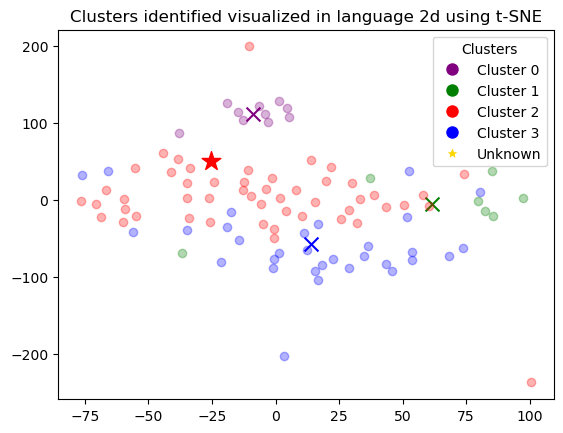

In [9]:
# Visualize data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
combined_data = np.vstack((matrix, unknown_embedding))
vis_dims2 = tsne.fit_transform(combined_data)

# remove outliers
vis_dims2[vis_dims2 > 400] = np.nan

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

# Define colors for each cluster
cluster_colors = ["purple", "green", "red", "blue"]

# Create a dictionary to map cluster labels to their colors
cluster_color_map = {label: color for label, color in enumerate(cluster_colors)}

for category in range(len(cluster_colors)):
    xs = np.array(x)[df[df.Cluster == category].index]
    ys = np.array(y)[df[df.Cluster == category].index]

    # Use the cluster_color_map to get the color for the current cluster
    color = cluster_color_map[category]
    
    plt.scatter(xs, ys, color=color, alpha=0.3, label=f'Cluster {category}')


    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")
# Plot the unknown embeddings

unknown_x, unknown_y = vis_dims2[-1] 
predicted_color = cluster_color_map[predicted_label]
plt.scatter(unknown_x, unknown_y, color=predicted_color, marker='*', s=200, label=f'Unknown Cluster {predicted_label}')

# Create a legend with cluster labels and colors
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Cluster {category}') for category, color in enumerate(cluster_colors)]
legend_elements.append(plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='gold', markersize=10, label='Unknown'))
plt.legend(handles=legend_elements, title='Clusters')


plt.show()

In [10]:
# LLAMA 7B
# Use gpt to evaluate 5 random articles in the different clusters to find similarities
article_per_cluster = 5
# file to append results
file_path = "./results/openai_cluster_estimations_LLAMA_7B.txt"
for i in range(n_clusters):
    print(f"Cluster {i}:", end=" ")

    article_samples = df[df.Cluster == i].sample(article_per_cluster, random_state=42)
    article_texts = [
        f"Title: {sample['Title']}\n\nContent: {sample['Content']}"
        for _, sample in article_samples.iterrows()
    ]
    articles = "\n\n".join(article_texts)

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that finds commonalities among football news articles."},
            {"role": "user", "content": f'What do the following football news articles regarding transfers have in common, besides being about transfers? Your answers must be short and concise.\n\nNews reading:\n"""\n{articles}\n"""\n\nTheme: Please provide a brief summary.'}
        ],
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    conclusion = response["choices"][0]["message"]["content"].replace("\n", "") + "\n"
    print(conclusion)

    sample_cluster_rows = df[df.Cluster == i].sample(article_per_cluster, random_state=42)
    with open(file_path, 'a') as file:
        file.write("!!! GPT-3.5-turbo !!!\n")
        file.write(f"Cluster {i}: ")
        file.write(conclusion)
        for _, sample_row in sample_cluster_rows.iterrows():
            date = sample_row["Date"]
            link = sample_row["Link"]
            text = sample_row["Content"][:200] + "..."
            print(date, end=", ")
            print(link, end=":   ")
            print(text)
            file.write(f"{date}, {link}:   {text}\n")

        file.write("-" * 100 + "\n")
        print("-" * 100)


Cluster 0: The common theme among these football news articles regarding transfers is the speculation and discussions surrounding potential player movements and replacements in various clubs.

Aug 9, 2023, https://www.90min.com/posts/man-utd-target-new-centre-back-signing-west-ham-close-harry-maguire:   Manchester United are set to enter the transfer market to sign a new centre-back following the completion of Harry Maguire's Â£30m move to West Ham, 90min understands. Maguire is in discussions over a...
Aug 15, 2023, https://www.90min.com/posts/football-transfer-rumours-maguire-sale-tottenham-arsenal-interest-15-8-23:   90minÂ rounds up the latestÂ transfer news, rumours and gossip circulating around the world... West Ham could pull out of negotiations to sign Harry Maguire from Manchester United as the deal is takin...
Aug 11, 2023, https://www.90min.com/posts/football-transfer-rumours-tottenham-lukaku-real-madrid-goalkeeper-target-11-8-23:   90minÂ rounds up the latestÂ transfer news